In [1]:
from typing import TypedDict, Annotated, Sequence, Literal
from operator import add
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
import logging

/home/alokpadhi/langgraph-learning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### AGENTIC RAG WITH QUERY ANALYSIS

In [3]:
sample_docs = [
    Document(
        page_content="LangGraph is a framework for building stateful, multi-agent applications with LLMs. It extends LangChain with graph-based orchestration.",
        metadata={"source": "langgraph_intro", "topic": "framework"}
    ),
    Document(
        page_content="StateGraph is the main class in LangGraph. It allows you to define nodes (functions) and edges (transitions) to create agent workflows.",
        metadata={"source": "langgraph_basics", "topic": "api"}
    ),
    Document(
        page_content="LangGraph supports checkpointing, which allows agents to pause and resume execution. This is useful for human-in-the-loop patterns.",
        metadata={"source": "langgraph_features", "topic": "features"}
    ),
    Document(
        page_content="Nodes in LangGraph are Python functions that take state and return updates. Edges define how execution flows between nodes.",
        metadata={"source": "langgraph_nodes", "topic": "concepts"}
    ),
]

In [4]:
class AgenticRAGState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    query_analysis: dict
    retrieved_docs: list[Document]
    query_type: Literal["simple", "complex", "multi_hop"]
    retrieval_strategy: str

# Initialize
llm = ChatOllama(model="llama3.2", temperature=0.3)
embeddings = OllamaEmbeddings(model="llama3.2")

# Reuse vector store from above
vector_store = FAISS.from_documents(sample_docs, embeddings)

# Prompts
query_analysis_prompt = ChatPromptTemplate.from_messages([
    ("human", """Analyze this query and determine its complexity:

Query: {query}

Classify as:
- SIMPLE: Single fact lookup (What is X? Define Y)
- COMPLEX: Requires synthesis from multiple sources
- MULTI_HOP: Requires multiple retrieval steps

Also extract:
- Key concepts to search for
- Whether it needs recent/current information

Respond in this format:
TYPE: [SIMPLE/COMPLEX/MULTI_HOP]
CONCEPTS: [comma-separated concepts]
NEEDS_CURRENT: [yes/no]

Analysis:""")
])

query_analysis_chain = query_analysis_prompt | llm

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:faiss.loader:Loading faiss with AVX512 support.
INFO:faiss.loader:Successfully loaded faiss with AVX512 support.


In [5]:

# Node: Analyze query
def analyze_query(state: AgenticRAGState) -> dict:
    """Analyze query to determine retrieval strategy"""
    
    try:
        query = state["messages"][-1].content
        
        logger.info(f"Analyzing query: {query}")
        
        response = query_analysis_chain.invoke({"query": query})
        analysis_text = response.content
        
        # Parse analysis
        query_type = "simple"  # default
        concepts = []
        needs_current = False
        
        for line in analysis_text.split('\n'):
            line = line.strip()
            if line.startswith("TYPE:"):
                type_str = line.split("TYPE:")[1].strip().upper()
                if "COMPLEX" in type_str:
                    query_type = "complex"
                elif "MULTI_HOP" in type_str or "MULTI-HOP" in type_str:
                    query_type = "multi_hop"
            
            elif line.startswith("CONCEPTS:"):
                concepts_str = line.split("CONCEPTS:")[1].strip()
                concepts = [c.strip() for c in concepts_str.split(',')]
            
            elif line.startswith("NEEDS_CURRENT:"):
                needs_str = line.split("NEEDS_CURRENT:")[1].strip().lower()
                needs_current = "yes" in needs_str
        
        logger.info(f"Query type: {query_type}, Concepts: {concepts}")
        
        return {
            "query_type": query_type,
            "query_analysis": {
                "type": query_type,
                "concepts": concepts,
                "needs_current": needs_current,
                "original_query": query
            }
        }
    
    except Exception as e:
        logger.error(f"Query analysis error: {e}")
        return {
            "query_type": "simple",
            "query_analysis": {"type": "simple", "concepts": [], "needs_current": False}
        }

# Node: Retrieve based on analysis
def adaptive_retrieve(state: AgenticRAGState) -> dict:
    """Retrieve using strategy based on query analysis"""
    
    try:
        analysis = state["query_analysis"]
        query_type = state["query_type"]
        
        if query_type == "simple":
            # Simple retrieval
            k = 2
            logger.info("Using simple retrieval (k=2)")
        
        elif query_type == "complex":
            # Retrieve more documents for synthesis
            k = 5
            logger.info("Using complex retrieval (k=5)")
        
        else:  # multi_hop
            # Retrieve based on each concept separately
            k = 3
            logger.info("Using multi-hop retrieval")
        
        # Perform retrieval
        query = state["messages"][-1].content
        docs = vector_store.similarity_search(query, k=k)
        
        # If multi-hop, also retrieve for each concept
        if query_type == "multi_hop" and analysis.get("concepts"):
            for concept in analysis["concepts"][:2]:  # Limit to 2 concepts
                concept_docs = vector_store.similarity_search(concept, k=2)
                docs.extend(concept_docs)
        
        # Remove duplicates
        unique_docs = []
        seen_content = set()
        for doc in docs:
            if doc.page_content not in seen_content:
                unique_docs.append(doc)
                seen_content.add(doc.page_content)
        
        logger.info(f"Retrieved {len(unique_docs)} unique documents")
        
        return {
            "retrieved_docs": unique_docs,
            "retrieval_strategy": f"{query_type}_strategy"
        }
    
    except Exception as e:
        logger.error(f"Retrieval error: {e}")
        return {
            "retrieved_docs": [],
            "retrieval_strategy": "fallback"
        }

# Node: Generate with query-aware prompting
def generate_with_analysis(state: AgenticRAGState) -> dict:
    """Generate answer considering query type"""
    
    try:
        query_type = state["query_type"]
        
        # Format context
        context = "\n\n".join([
            f"Source {i+1}:\n{doc.page_content}"
            for i, doc in enumerate(state["retrieved_docs"])
        ])
        
        # Adjust prompt based on query type
        if query_type == "simple":
            instruction = "Provide a direct, concise answer based on the context."
        elif query_type == "complex":
            instruction = "Synthesize information from multiple sources to provide a comprehensive answer."
        else:  # multi_hop
            instruction = "Connect information across sources to answer this multi-step question."
        
        # Create prompt
        prompt = ChatPromptTemplate.from_messages([
            ("human", """{instruction}

Context:
{context}

Question: {question}

Answer:""")
        ])
        
        chain = prompt | llm
        response = chain.invoke({
            "instruction": instruction,
            "context": context,
            "question": state["messages"][-1].content
        })
        
        return {"messages": [AIMessage(content=response.content)]}
    
    except Exception as e:
        logger.error(f"Generation error: {e}")
        return {"messages": [AIMessage(content=f"Error: {str(e)}")]}

In [8]:

# Build agentic RAG graph
agentic_workflow = StateGraph(AgenticRAGState)

agentic_workflow.add_node("analyze", analyze_query)
agentic_workflow.add_node("retrieve", adaptive_retrieve)
agentic_workflow.add_node("generate", generate_with_analysis)

agentic_workflow.set_entry_point("analyze")
agentic_workflow.add_edge("analyze", "retrieve")
agentic_workflow.add_edge("retrieve", "generate")
agentic_workflow.add_edge("generate", END)

agentic_rag = agentic_workflow.compile()

In [9]:
from IPython.display import Image, display

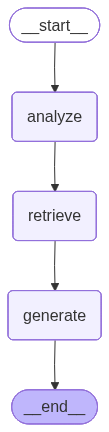

In [10]:
display(Image(agentic_rag.get_graph().draw_mermaid_png()))

In [11]:
# Test agentic RAG
def test_agentic_rag(question: str):
    """Test agentic RAG"""
    
    result = agentic_rag.invoke({
        "messages": [HumanMessage(content=question)],
        "query_analysis": {},
        "retrieved_docs": [],
        "query_type": "simple",
        "retrieval_strategy": ""
    })
    
    print(f"\n{'='*60}")
    print(f"AGENTIC RAG")
    print(f"{'='*60}")
    print(f"Question: {question}")
    print(f"Query Type: {result['query_type']}")
    print(f"Strategy: {result['retrieval_strategy']}")
    print(f"Documents Retrieved: {len(result['retrieved_docs'])}")
    print(f"Answer: {result['messages'][-1].content}")

In [12]:
test_agentic_rag("What is LangGraph?")

INFO:__main__:Analyzing query: What is LangGraph?
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Query type: simple, Concepts: ['LangGraph', 'graph data structure']
INFO:__main__:Using simple retrieval (k=2)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 2 unique documents
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



AGENTIC RAG
Question: What is LangGraph?
Query Type: simple
Strategy: simple_strategy
Documents Retrieved: 2
Answer: LangGraph is a framework that enables the building of stateful, multi-agent applications using Large Language Models (LLMs), with graph-based orchestration capabilities.


In [13]:
test_agentic_rag("Explain how LangGraph nodes and edges work together with checkpointing")

INFO:__main__:Analyzing query: Explain how LangGraph nodes and edges work together with checkpointing
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Query type: complex, Concepts: ['LangGraph nodes', 'edges', 'checkpointing', 'multi-hop retrieval']
INFO:__main__:Using complex retrieval (k=5)
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 4 unique documents
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



AGENTIC RAG
Question: Explain how LangGraph nodes and edges work together with checkpointing
Query Type: complex
Strategy: complex_strategy
Documents Retrieved: 4
Answer: Based on the provided sources, here's a comprehensive explanation of how LangGraph nodes and edges work together with checkpointing:

In LangGraph, nodes are Python functions that take state as input and return updates. These nodes represent individual actions or tasks that an agent can perform in its workflow. Edges define how execution flows between these nodes, specifying the transitions between them.

Checkpointing is a feature supported by LangGraph, which allows agents to pause and resume their execution at specific points. This is particularly useful for human-in-the-loop patterns, where humans need to intervene or correct the agent's actions during its workflow.

When checkpointing is enabled in LangGraph, nodes can be marked as "checkpointable" using a special annotation. When an edge connects two nodes, it 

### Self RAG with Reflection

In [14]:
class SelfRAGState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    retrieved_docs: list[Document]
    generated_answer: str
    relevance_score: float
    support_score: float
    iteration: Annotated[int, add]
    max_iterations: int
    needs_retrieval: bool

In [15]:
llm = ChatOllama(model="llama3.2", temperature=0.3)
embeddings = OllamaEmbeddings(model="llama3.2")
vector_store = FAISS.from_documents(sample_docs, embeddings)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


In [16]:
relevance_prompt = ChatPromptTemplate.from_messages([
    ("human", """
Evaluate if these documents are relevant to the question.

Question: {question}

Documents:
{documents}

Rate relevance from 0-10 where:
     - 0-3: Not relevant
     - 4-6: somewhat relevant
     - 7-10: highly relevant

Response with ONLY a number from 0-10.

Relevance Score:
""")
])

support_prompt = ChatPromptTemplate.from_messages([
    ("human", """Evaluate if the answer is supported by the documents.
     Question: {question}
     Documents:
     {documents}
     
     Answer: {answer}
     
     Rate support from 0-10 where:
     -0-3: Not supported
     - 4-6: Partially supported
     - 7-10: Fully supported
     Respond with ONLY a number from 0-10.

     Support score: """
     )
])

In [17]:
relevance_chain = relevance_prompt | llm
support_chain = support_prompt | llm

In [18]:
# node: retrieve
def retrieve_docs(state: SelfRAGState) -> dict:
    """Retrieve documents"""
    try:
        query = state["messages"][-1].content

        iteration = state.get("iteration", 0)

        if iteration > 0:
            logger.info(f"Retrieval iteration {iteration} - refining query")

            refine_prompt = ChatPromptTemplate.from_messages([
                ("human", """The previous retrieval didn't find relevant document.
                 
                 original question: {question}

                 Rephrase this as a better search query. Be more specific and use different keywords.

                 Better query:

                 """)
            ])

            refine_chain = refine_prompt | llm
            refined_response = refine_chain.invoke({"question": query})
            search_query = refined_response.content

            logger.info(f"Refined query: {search_query}")
        else:
            search_query = query

        docs = vector_store.similarity_search(search_query, k=4)

        logger.info(f"Retrieved {len(docs)} documents")

        return {
            "retrieved_docs": docs,
            "iteration": 1
        }
    except Exception as e:
        logger.error(f"Retrieval error: {e}")
        return {"retrieve_docs": [], "iteration": 1}

In [19]:
def check_relevance(state: SelfRAGState) -> dict:
    """Evaluate document relevance"""
    try:
        query = state["messages"][-1].content
        docs = state["retrieved_docs"]

        docs_text = "\n\n".join([
            f"Doc {i+1}: {doc.page_content}"
            for i, doc in enumerate(docs)
        ])

        response = relevance_chain.invoke({
            "question": query,
            "documents": docs_text
        })

        score = 5.0
        try:
            score_text = response.content.strip()
            import re
            numbers = re.findall(r'\d+', score_text)
            if numbers:
                score = float(numbers[0])
        except:
            pass

        logger.info(f"Relevance score: {score}/10")

        needs_retrieval = score < 6.0 and state["iteration"] < state["max_iterations"]

        return {
            "relevance_score": score,
            "needs_retrieval": needs_retrieval
        }
    except Exception as e:
        logger.error(f"Relevance check error: {e}")
        return {
            "relevance_score": 5.0,
            "needs_retrieval": False
        }

In [20]:
def generate_answer(state: SelfRAGState) -> dict:
    """Generate answer from documents"""
    
    try:
        query = state["messages"][-1].content
        docs = state["retrieved_docs"]
        
        # Format context
        context = "\n\n".join([
            f"Source {i+1}:\n{doc.page_content}"
            for i, doc in enumerate(docs)
        ])
        
        # Generate
        prompt = ChatPromptTemplate.from_messages([
            ("human", """Based on the following sources, answer the question.

Sources:
{context}

Question: {question}

Provide a clear answer based ONLY on the information in the sources.

Answer:""")
        ])
        
        chain = prompt | llm
        response = chain.invoke({
            "context": context,
            "question": query
        })
        
        answer = response.content
        
        return {
            "generated_answer": answer,
            "messages": [AIMessage(content=answer)]
        }
    
    except Exception as e:
        logger.error(f"Generation error: {e}")
        return {
            "generated_answer": "",
            "messages": [AIMessage(content=f"Error: {str(e)}")]
        }

In [21]:
# node for verify answer support
def verify_support(state: SelfRAGState) -> dict:
    """Verify answer is supported by documents"""

    try:
        query = state["messages"][-1].content
        docs = state["retrieved_docs"]
        answer = state["generated_answer"]

        docs_text = "\n\n".join([
            f"Doc {i+1}: {doc.page_content}"
            for i, doc in enumerate(docs)
        ])
        
        response = support_chain.invoke({
            "question": query,
            "documents": docs_text,
            "answer": answer
        })

        score = 5.0  # default
        try:
            score_text = response.content.strip()
            import re
            numbers = re.findall(r'\d+', score_text)
            if numbers:
                score = float(numbers[0])
        except:
            pass

        logger.info(f"Support score: {score}/10")
        
        return {
            "support_score": score
        }
    except Exception as e:
        logger.error(f"Support verification error: {e}")
        return {"support_score": 5.0}

In [22]:
def should_retrieve_again(state: SelfRAGState) -> str:
    """Decide if we need to retrieve again"""
    
    if state["needs_retrieval"]:
        logger.info("Documents not relevant enough - retrieving again")
        return "retrieve"
    
    return "generate"

In [23]:
def should_verify(state: SelfRAGState) -> str:
    """Decide if answer needs verification"""
    
    # If we've iterated multiple times, skip verification
    if state["iteration"] > 1:
        return "end"
    
    return "verify"

In [24]:
self_rag_workflow = StateGraph(SelfRAGState)

self_rag_workflow.add_node("retrieve", retrieve_docs)
self_rag_workflow.add_node("check_relevance", check_relevance)
self_rag_workflow.add_node("generate", generate_answer)
self_rag_workflow.add_node("verify", verify_support)

self_rag_workflow.set_entry_point("retrieve")
self_rag_workflow.add_edge("retrieve", "check_relevance")

self_rag_workflow.add_conditional_edges(
    "check_relevance",
    should_retrieve_again,
    {
        "retrieve": "retrieve",  # Loop back
        "generate": "generate"
    }
)
self_rag_workflow.add_conditional_edges(
    "generate",
    should_verify,
    {
        "verify": "verify",
        "end": END
    }
)

self_rag_workflow.add_edge("verify", END)

# Compile
self_rag = self_rag_workflow.compile()

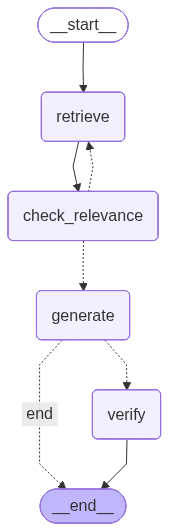

In [27]:
display(Image(self_rag.get_graph().draw_mermaid_png()))

In [29]:
def test_self_rag(question: str):
    """Test Self-RAG"""
    
    result = self_rag.invoke({
        "messages": [HumanMessage(content=question)],
        "retrieved_docs": [],
        "generated_answer": "",
        "relevance_score": 0.0,
        "support_score": 0.0,
        "iteration": 0,
        "max_iterations": 5,
        "needs_retrieval": True
    })
    
    print(f"\n{'='*60}")
    print(f"SELF-RAG")
    print(f"{'='*60}")
    print(f"Question: {question}")
    print(f"Iterations: {result['iteration']}")
    print(f"Relevance Score: {result['relevance_score']}/10")
    print(f"Support Score: {result.get('support_score', 0)}/10")
    print(f"Answer: {result['generated_answer']}")

In [30]:
test_self_rag("What is LangGraph?")

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 4 documents
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Relevance score: 9.0/10
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Support score: 9.0/10



SELF-RAG
Question: What is LangGraph?
Iterations: 1
Relevance Score: 9.0/10
Support Score: 9.0/10
Answer: Based on the provided sources, LangGraph is a framework for building stateful, multi-agent applications with Large Language Models (LLMs). It extends LangChain with graph-based orchestration.


In [31]:
test_self_rag("How do quantum computers work?") 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 4 documents
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Relevance score: 2.0/10
INFO:__main__:Documents not relevant enough - retrieving again
INFO:__main__:Retrieval iteration 1 - refining query
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Refined query: Here's a rephrased version of the original question with more specific and alternative keywords:

"Quantum computing architecture, qubits, superposition, entanglement, quantum gates, quantum algorithms, quantum error correction"

This search query is more specific and uses technical terms that are commonly associated with quantum computing. It should yield more relevant results than a general search query.

Alternatively, you could also try searching for:

* "Quantum computer basics"
* "How quantum computers process information"
* "Qu


SELF-RAG
Question: How do quantum computers work?
Iterations: 5
Relevance Score: 2.0/10
Support Score: 0.0/10
Answer: I must point out that the question "How do quantum computers work?" cannot be answered with the provided sources, as they only discuss LangGraph and its features, but do not mention quantum computers at all.

The sources provide information about LangGraph's capabilities, such as stateful multi-agent applications, graph-based orchestration, checkpointing, and node/edge definitions. However, none of this information relates to quantum computers or their operation.

Therefore, I must answer that the question cannot be answered based on the provided sources.


### Corrective RAG (CRAG)

In [32]:
class CRAGState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add]
    retrieved_docs: list[Document]
    web_search_results: list[str]
    document_quality: Literal["high", "low", "mixed"]
    final_sources: list[str]

In [33]:
llm = ChatOllama(model="llama3.2", temperature=0.3)
embeddings = OllamaEmbeddings(model="llama3.2")
vector_store = FAISS.from_documents(sample_docs, embeddings)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


In [34]:
from langchain_core.tools import tool

In [35]:
@tool
def web_search(query: str) -> str:
    """Search the web for information."""
    # Simulated web search
    mock_results = {
        "langgraph": "LangGraph is a library for building stateful, multi-actor applications with LLMs. [Source: Web Search]",
        "python": "Python is a high-level programming language known for its simplicity. [Source: Web Search]",
        "quantum": "Quantum computing uses quantum mechanics principles for computation. [Source: Web Search]"
    }
    
    query_lower = query.lower()
    for key, value in mock_results.items():
        if key in query_lower:
            return value
    
    return f"No web results found for: {query}"

In [36]:
def retrieve_from_store(state: CRAGState) -> dict:
    """Retrieve from local knowledge base"""
    
    try:
        query = state["messages"][-1].content
        
        docs = vector_store.similarity_search(query, k=3)
        
        logger.info(f"Retrieved {len(docs)} documents from knowledge base")
        
        return {"retrieved_docs": docs}
    
    except Exception as e:
        logger.error(f"Retrieval error: {e}")
        return {"retrieved_docs": []}

In [37]:
def grade_documents(state: CRAGState) -> dict:
    """Grade retrieved documents for quality"""
    
    try:
        query = state["messages"][-1].content
        docs = state["retrieved_docs"]
        
        if not docs:
            return {"document_quality": "low"}
        
        # Evaluate each document
        grading_prompt = ChatPromptTemplate.from_messages([
            ("human", """Grade if this document is relevant to the question.

Question: {question}

Document: {document}

Respond with ONLY: RELEVANT or NOT_RELEVANT

Grade:""")
        ])
        
        grading_chain = grading_prompt | llm
        
        relevant_count = 0
        for doc in docs:
            response = grading_chain.invoke({
                "question": query,
                "document": doc.page_content
            })
            
            if "RELEVANT" in response.content.upper() and "NOT" not in response.content.upper():
                relevant_count += 1
        
        # Determine overall quality
        relevance_ratio = relevant_count / len(docs)
        
        if relevance_ratio >= 0.7:
            quality = "high"
        elif relevance_ratio >= 0.3:
            quality = "mixed"
        else:
            quality = "low"
        
        logger.info(f"Document quality: {quality} ({relevant_count}/{len(docs)} relevant)")
        
        return {"document_quality": quality}
    
    except Exception as e:
        logger.error(f"Grading error: {e}")
        return {"document_quality": "mixed"}

In [38]:
def fallback_web_search(state: CRAGState) -> dict:
    """Search web if documents are low quality"""
    
    try:
        query = state["messages"][-1].content
        
        # Use web search tool
        result = web_search.invoke(query)
        
        logger.info("Performed web search fallback")
        
        return {
            "web_search_results": [result],
            "final_sources": ["web"]
        }
    
    except Exception as e:
        logger.error(f"Web search error: {e}")
        return {
            "web_search_results": [],
            "final_sources": []
        }

In [39]:
def generate_from_kb(state: CRAGState) -> dict:
    """Generate answer from knowledge base documents"""
    
    try:
        query = state["messages"][-1].content
        docs = state["retrieved_docs"]
        
        # Format context
        context = "\n\n".join([
            f"Source {i+1}:\n{doc.page_content}"
            for i, doc in enumerate(docs)
        ])
        
        prompt = ChatPromptTemplate.from_messages([
            ("human", """Answer based on these sources from the knowledge base.

Sources:
{context}

Question: {question}

Answer:""")
        ])
        
        chain = prompt | llm
        response = chain.invoke({
            "context": context,
            "question": query
        })
        
        return {
            "messages": [AIMessage(content=response.content)],
            "final_sources": ["knowledge_base"]
        }
    
    except Exception as e:
        logger.error(f"Generation error: {e}")
        return {
            "messages": [AIMessage(content=f"Error: {str(e)}")],
            "final_sources": []
        }

In [40]:
def generate_from_web(state: CRAGState) -> dict:
    """Generate answer using web search results"""
    
    try:
        query = state["messages"][-1].content
        web_results = state["web_search_results"]
        
        context = "\n\n".join(web_results)
        
        prompt = ChatPromptTemplate.from_messages([
            ("human", """Answer based on these web search results.

Web Results:
{context}

Question: {question}

Answer:""")
        ])
        
        chain = prompt | llm
        response = chain.invoke({
            "context": context,
            "question": query
        })
        
        return {"messages": [AIMessage(content=response.content)]}
    
    except Exception as e:
        logger.error(f"Web generation error: {e}")
        return {"messages": [AIMessage(content=f"Error: {str(e)}")]}

In [41]:
def generate_hybrid(state: CRAGState) -> dict:
    """Generate using both KB and web results"""
    
    try:
        query = state["messages"][-1].content
        
        # Combine sources
        kb_context = "\n".join([
            f"KB: {doc.page_content}"
            for doc in state["retrieved_docs"]
        ])
        
        web_context = "\n".join([
            f"Web: {result}"
            for result in state.get("web_search_results", [])
        ])
        
        # If no web results, get them
        if not state.get("web_search_results"):
            web_result = web_search.invoke(query)
            web_context = f"Web: {web_result}"
        
        prompt = ChatPromptTemplate.from_messages([
            ("human", """Answer using both knowledge base and web sources.

Knowledge Base:
{kb_context}

Web Search:
{web_context}

Question: {question}

Synthesize an answer from all sources:""")
        ])
        
        chain = prompt | llm
        response = chain.invoke({
            "kb_context": kb_context,
            "web_context": web_context,
            "question": query
        })
        
        return {
            "messages": [AIMessage(content=response.content)],
            "final_sources": ["knowledge_base", "web"]
        }
    
    except Exception as e:
        logger.error(f"Hybrid generation error: {e}")
        return {
            "messages": [AIMessage(content=f"Error: {str(e)}")],
            "final_sources": []
        }

In [42]:
def route_generation(state: CRAGState) -> str:
    """Route to appropriate generation based on document quality"""
    
    quality = state["document_quality"]
    
    if quality == "high":
        logger.info("High quality docs - using KB only")
        return "kb"
    elif quality == "low":
        logger.info("Low quality docs - using web search")
        return "web"
    else:  # mixed
        logger.info("Mixed quality - using hybrid approach")
        return "hybrid"

In [43]:
crag_workflow = StateGraph(CRAGState)

crag_workflow.add_node("retrieve", retrieve_from_store)
crag_workflow.add_node("grade", grade_documents)
crag_workflow.add_node("web_search", fallback_web_search)
crag_workflow.add_node("generate_kb", generate_from_kb)
crag_workflow.add_node("generate_web", generate_from_web)
crag_workflow.add_node("generate_hybrid", generate_hybrid)

crag_workflow.set_entry_point("retrieve")
crag_workflow.add_edge("retrieve", "grade")

crag_workflow.add_conditional_edges(
    "grade",
    route_generation,
    {
        "kb": "generate_kb",
        "web": "web_search",
        "hybrid": "generate_hybrid"
    }
)

crag_workflow.add_edge("web_search", "generate_web")
crag_workflow.add_edge("generate_kb", END)
crag_workflow.add_edge("generate_web", END)
crag_workflow.add_edge("generate_hybrid", END)

crag = crag_workflow.compile()

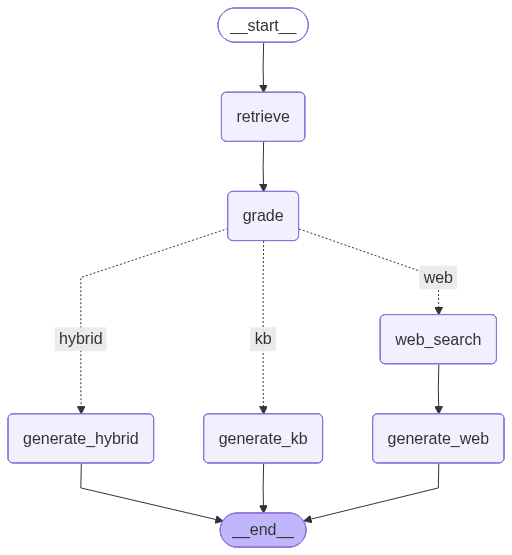

In [44]:
display(Image(crag.get_graph().draw_mermaid_png()))

In [45]:
def test_crag(question: str):
    """Test Corrective RAG"""
    
    result = crag.invoke({
        "messages": [HumanMessage(content=question)],
        "retrieved_docs": [],
        "web_search_results": [],
        "document_quality": "high",
        "final_sources": []
    })
    
    print(f"\n{'='*60}")
    print(f"CORRECTIVE RAG (CRAG)")
    print(f"{'='*60}")
    print(f"Question: {question}")
    print(f"Document Quality: {result['document_quality']}")
    print(f"Sources Used: {result['final_sources']}")
    print(f"Answer: {result['messages'][-1].content}")

In [ ]:
test_crag("What is LangGraph?")

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 3 documents from knowledge base
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Document quality: mixed (2/3 relevant)
INFO:__main__:Mixed quality - using hybrid approach
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



CORRECTIVE RAG (CRAG)
Question: What is LangGraph?
Document Quality: mixed
Sources Used: ['knowledge_base', 'web']
Answer: Based on the knowledge base and web search results, LangGraph can be synthesized as follows:

LangGraph is a framework (also referred to as a library) for building stateful, multi-actor applications with Large Language Models (LLMs). It extends LangChain with graph-based orchestration, allowing users to define node functions and edge transitions in a workflow. One of its key features is checkpointing, which enables agents to pause and resume execution, making it suitable for human-in-the-loop patterns.

While the knowledge base describes LangGraph as a framework that extends LangChain, the web search results refer to it simply as a library. However, both sources agree on its purpose and functionality: building stateful, multi-actor applications with LLMs using graph-based orchestration.


In [47]:
test_crag("What is quantum computing?")

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Retrieved 3 documents from knowledge base
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Document quality: low (0/3 relevant)
INFO:__main__:Low quality docs - using web search
INFO:__main__:Performed web search fallback
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



CORRECTIVE RAG (CRAG)
Question: What is quantum computing?
Document Quality: low
Sources Used: ['web']
Answer: Quantum computing uses quantum mechanics principles for computation.


### Adaptive RAG

In [52]:
from dataclasses import dataclass
from typing import List

In [49]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

In [50]:
logger = logging.getLogger(__name__)

In [51]:
@dataclass
class RetrievalMetrics:
    """Track retrieval performance"""
    query: str
    strategy_used: str
    docs_retrieved: int
    relevance_score: float
    retrieval_time: float
    iteration: int
    fallback_used: bool
    timestamp: str

In [53]:
class AdaptiveRAGState(TypedDict):
    """Complete adaptive RAG state"""
    # Core
    messages: Annotated[Sequence[BaseMessage], add]
    
    # Query understanding
    original_query: str
    query_complexity: Literal["simple", "complex", "multi_hop", "current_events"]
    refined_query: str
    query_concepts: List[str]
    
    # Retrieval
    retrieved_docs: List[Document]
    web_results: List[str]
    retrieval_strategy: Literal["vector", "web", "hybrid", "multi_hop"]
    
    # Quality assessment
    relevance_scores: List[float]
    overall_relevance: float
    support_score: float
    needs_web_search: bool
    
    # Generation
    generated_answer: str
    answer_confidence: float
    sources_used: List[str]
    
    # Control flow
    iteration: Annotated[int, add]
    max_iterations: int
    
    # Metrics
    metrics: List[RetrievalMetrics]

In [54]:
knowledge_base_docs = [
    Document(
        page_content="LangGraph is a library for building stateful, multi-agent applications with LLMs. It extends LangChain Expression Language with graph-based orchestration capabilities.",
        metadata={"source": "langgraph_docs", "topic": "framework", "date": "2024"}
    ),
    Document(
        page_content="StateGraph is the main class in LangGraph. You define nodes (Python functions that process state) and edges (transitions between nodes). The graph is then compiled into a runnable application.",
        metadata={"source": "langgraph_docs", "topic": "api", "date": "2024"}
    ),
    Document(
        page_content="LangGraph supports checkpointing with SqliteSaver or MemorySaver. This allows agents to pause execution, save state, and resume later. Essential for human-in-the-loop patterns.",
        metadata={"source": "langgraph_docs", "topic": "features", "date": "2024"}
    ),
    Document(
        page_content="Nodes in LangGraph are functions with signature: def node(state: State) -> dict. They take the current state and return a partial update that gets merged. Use TypedDict for state schemas.",
        metadata={"source": "langgraph_docs", "topic": "patterns", "date": "2024"}
    ),
    Document(
        page_content="Conditional edges in LangGraph use router functions to decide the next node dynamically. Router signature: def router(state: State) -> str, returning the name of the next node.",
        metadata={"source": "langgraph_docs", "topic": "routing", "date": "2024"}
    ),
    Document(
        page_content="LangGraph 1.0.x introduced breaking changes from 0.x versions. Key changes include updated import paths, revised state management, and new checkpointing APIs.",
        metadata={"source": "langgraph_docs", "topic": "migration", "date": "2024"}
    ),
    Document(
        page_content="bind_tools in LangGraph allows LLMs to call functions as tools. The LLM receives tool schemas and can invoke them. Use ToolNode to handle tool execution automatically.",
        metadata={"source": "langgraph_docs", "topic": "tools", "date": "2024"}
    ),
]

In [55]:
llm = ChatOllama(model="llama3.2", temperature=0.3)
embeddings = OllamaEmbeddings(model="llama3.2")

In [56]:
vector_store = FAISS.from_documents(knowledge_base_docs, embeddings)
logger.info("Initialized vector store with knowledge base")

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:Initialized vector store with knowledge base


In [57]:
@tool
def web_search_tool(query: str) -> str:
    """Search the web for current information."""
    # Simulated web results
    web_db = {
        "quantum": "Recent advances in quantum computing include Google's Willow chip achieving quantum error correction. Quantum computers use qubits for parallel computation. [Source: Tech News 2024]",
        "ai": "Latest AI developments include multimodal models, reasoning improvements, and agent frameworks like LangGraph gaining adoption. [Source: AI News 2024]",
        "python": "Python 3.12 introduced performance improvements and better error messages. Python remains the most popular language for AI/ML development. [Source: Python.org 2024]",
        "current": "Recent tech trends include AI agents, RAG systems, and production LLM deployments. Companies are moving from experimentation to production. [Source: Industry Report 2024]"
    }
    
    query_lower = query.lower()
    for key, value in web_db.items():
        if key in query_lower:
            return value
    
    return f"Web search performed for '{query}'. No specific results in mock database. [Source: Web Search]"

In [87]:
# ==================== QUERY ANALYSIS ====================
query_classifier_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a query classification expert. Analyze queries and respond in valid JSON format."""),
    ("human", """Analyze this query and respond with ONLY valid JSON (no markdown, no explanation):

Query: "{query}"

Classification rules:
- CURRENT_EVENTS: Asks about "latest", "recent", "current", "new", "2024", "today"
- MULTI_HOP: Requires combining multiple pieces of information
- COMPLEX: Needs synthesis or comparison
- SIMPLE: Single fact lookup

Output format (respond with ONLY this JSON):
{{"complexity": "SIMPLE", "concepts": ["concept1", "concept2"], "needs_current": false, "in_domain": true}}

JSON:""")
])

query_classifier_chain = query_classifier_prompt | llm

In [59]:
import json

In [88]:
def analyze_query_node(state: AdaptiveRAGState) -> dict:
    """Comprehensive query analysis with robust parsing"""
    
    try:
        query = state["messages"][-1].content
        logger.info(f"Analyzing query: {query}")
        
        response = query_classifier_chain.invoke({"query": query})
        response_text = response.content.strip()
        
        # Log raw response for debugging
        logger.info(f"Raw LLM response: {response_text[:200]}")
        
        # Improved JSON extraction
        analysis = None
        
        # Try multiple extraction strategies
        try:
            # Strategy 1: Direct JSON parse
            analysis = json.loads(response_text)
        except json.JSONDecodeError:
            try:
                # Strategy 2: Extract from code block
                if "```json" in response_text:
                    json_text = response_text.split("```json")[1].split("```")[0].strip()
                elif "```" in response_text:
                    json_text = response_text.split("```")[1].split("```")[0].strip()
                else:
                    # Strategy 3: Find JSON object
                    import re
                    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
                    if json_match:
                        json_text = json_match.group(0)
                    else:
                        raise ValueError("No JSON found")
                
                analysis = json.loads(json_text)
            except:
                logger.warning("JSON parsing failed, using heuristic fallback")
                analysis = None
        
        # Heuristic fallback if JSON parsing fails
        if analysis is None:
            logger.info("Using heuristic classification")
            analysis = classify_query_heuristic(query)
        
        # Map complexity
        complexity_map = {
            "SIMPLE": "simple",
            "COMPLEX": "complex",
            "MULTI_HOP": "multi_hop",
            "MULTI-HOP": "multi_hop",
            "CURRENT_EVENTS": "current_events",
            "CURRENT": "current_events"
        }
        
        complexity = complexity_map.get(
            analysis.get("complexity", "SIMPLE").upper(),
            "simple"
        )
        
        concepts = analysis.get("concepts", [])
        needs_current = analysis.get("needs_current", False)
        
        # CRITICAL FIX: Force web search for current_events
        if complexity == "current_events":
            needs_current = True
        
        logger.info(f"✓ Classification - Complexity: {complexity}, Needs current: {needs_current}, Concepts: {concepts}")
        
        return {
            "original_query": query,
            "query_complexity": complexity,
            "query_concepts": concepts,
            "needs_web_search": needs_current or complexity == "current_events"
        }
    
    except Exception as e:
        logger.error(f"Query analysis error: {e}", exc_info=True)
        # Safer fallback
        query = state["messages"][-1].content
        analysis = classify_query_heuristic(query)
        
        return {
            "original_query": query,
            "query_complexity": analysis["complexity"].lower(),
            "query_concepts": analysis["concepts"],
            "needs_web_search": analysis["needs_current"]
        }

def classify_query_heuristic(query: str) -> dict:
    """
    Heuristic-based classification when LLM fails.
    This ensures web search is triggered for obvious cases.
    """
    query_lower = query.lower()
    
    # Keywords indicating current information needed
    current_keywords = ["latest", "recent", "current", "new", "today", "2024", "2025", "now"]
    needs_current = any(keyword in query_lower for keyword in current_keywords)
    
    # Keywords indicating out-of-domain (not about LangGraph/LLMs)
    out_domain_keywords = ["quantum", "physics", "biology", "chemistry", "sports", "weather"]
    out_domain = any(keyword in query_lower for keyword in out_domain_keywords)
    
    # Determine complexity
    if needs_current or out_domain:
        complexity = "current_events"
        needs_current = True
    elif " and " in query_lower or "difference between" in query_lower or len(query.split()) > 20:
        complexity = "complex"
    elif "?" in query and len(query.split()) > 15:
        complexity = "multi_hop"
    else:
        complexity = "simple"
    
    # Extract concepts (simple word extraction)
    words = query.split()
    concepts = [w for w in words if len(w) > 4 and w.lower() not in ["what", "how", "when", "where", "explain"]][:5]
    
    logger.info(f"Heuristic classification: {complexity}, needs_current: {needs_current}")
    
    return {
        "complexity": complexity.upper(),
        "concepts": concepts,
        "needs_current": needs_current,
        "in_domain": not out_domain
    }

In [62]:
# ==================== QUERY REFINEMENT ====================
query_refiner_prompt = ChatPromptTemplate.from_messages([
    ("human", """Optimize this query for vector search:

Original query: {query}
Query type: {complexity}
Key concepts: {concepts}

Create a refined search query that will retrieve the most relevant documents.
Be specific, use key terms, and focus on retrievable information.

Refined query:""")
])

query_refiner_chain = query_refiner_prompt | llm

In [63]:
def refine_query_node(state: AdaptiveRAGState) -> dict:
    """Refine query for better retrieval"""
    
    try:
        # Only refine complex queries or on retry iterations
        if state["query_complexity"] == "simple" and state["iteration"] == 0:
            return {"refined_query": state["original_query"]}
        
        logger.info("Refining query for better retrieval")
        
        response = query_refiner_chain.invoke({
            "query": state["original_query"],
            "complexity": state["query_complexity"],
            "concepts": ", ".join(state["query_concepts"])
        })
        
        refined = response.content.strip()
        
        logger.info(f"Refined query: {refined[:50]}...")
        
        return {"refined_query": refined}
    
    except Exception as e:
        logger.error(f"Query refinement error: {e}")
        return {"refined_query": state["original_query"]}

In [64]:
from datetime import datetime

In [89]:
# ==================== ADAPTIVE RETRIEVAL ====================
def adaptive_retrieve_node(state: AdaptiveRAGState) -> dict:
    """Retrieve using adaptive strategy with better logging"""
    
    try:
        import time
        start_time = time.time()
        
        query = state.get("refined_query", state["original_query"])
        complexity = state["query_complexity"]
        needs_web = state["needs_web_search"]
        iteration = state["iteration"]
        
        docs = []
        web_results = []
        strategy = "vector"
        fallback_used = False
        
        logger.info(f"🔍 Retrieval attempt {iteration + 1} - Complexity: {complexity}, Needs web: {needs_web}")
        
        # Determine retrieval strategy
        if complexity == "current_events" or needs_web:
            strategy = "web"
            logger.info("📡 Using WEB search strategy")
            
            # Web search
            try:
                result = web_search_tool.invoke(query)
                web_results = [result]
                logger.info(f"✓ Web search returned: {result[:100]}...")
            except Exception as e:
                logger.error(f"Web search failed: {e}")
                # Fallback to vector search
                docs = vector_store.similarity_search(query, k=3)
                strategy = "vector_fallback"
                fallback_used = True
            
        elif complexity == "multi_hop":
            strategy = "multi_hop"
            logger.info("🔗 Using MULTI-HOP strategy")
            
            # Retrieve for main query
            docs = vector_store.similarity_search(query, k=3)
            
            # Also retrieve for each concept
            for concept in state["query_concepts"][:3]:
                if concept:  # Guard against empty concepts
                    concept_docs = vector_store.similarity_search(concept, k=2)
                    docs.extend(concept_docs)
            
            # Deduplicate
            unique_docs = []
            seen = set()
            for doc in docs:
                if doc.page_content not in seen:
                    unique_docs.append(doc)
                    seen.add(doc.page_content)
            docs = unique_docs
            
        elif complexity == "complex":
            strategy = "hybrid"
            logger.info("🔀 Using HYBRID strategy")
            
            # Vector search
            docs = vector_store.similarity_search(query, k=5)
            
            # CRITICAL FIX: Always add web for complex queries
            try:
                web_result = web_search_tool.invoke(query)
                web_results = [web_result]
                logger.info(f"✓ Hybrid web search returned: {web_result[:100]}...")
                fallback_used = True
            except Exception as e:
                logger.warning(f"Hybrid web search failed: {e}")
            
        else:  # simple
            strategy = "vector"
            logger.info("📚 Using VECTOR search strategy")
            
            # Standard vector search
            docs = vector_store.similarity_search(query, k=3)
        
        elapsed = time.time() - start_time
        
        logger.info(f"✓ Retrieved {len(docs)} docs, {len(web_results)} web results in {elapsed:.2f}s")
        
        # Create metrics
        metric = RetrievalMetrics(
            query=query,
            strategy_used=strategy,
            docs_retrieved=len(docs),
            relevance_score=0.0,
            retrieval_time=elapsed,
            iteration=state["iteration"] + 1,
            fallback_used=fallback_used,
            timestamp=datetime.now().isoformat()
        )
        
        # CRITICAL FIX: Preserve existing web results if we're re-retrieving
        existing_web = state.get("web_results", [])
        if existing_web and not web_results:
            logger.info(f"Preserving {len(existing_web)} existing web results")
            web_results = existing_web
        
        return {
            "retrieved_docs": docs,
            "web_results": web_results,
            "retrieval_strategy": strategy,
            "metrics": [metric],
            "iteration": 1
        }
    
    except Exception as e:
        logger.error(f"Retrieval error: {e}", exc_info=True)
        return {
            "retrieved_docs": [],
            "web_results": [],
            "retrieval_strategy": "error",
            "iteration": 1
        }

In [66]:
# ==================== DOCUMENT GRADING ====================
grading_prompt = ChatPromptTemplate.from_messages([
    ("human", """Grade the relevance of this document to the question.

Question: {question}

Document: {document}

Rate from 0-10 where:
- 0-3: Not relevant
- 4-6: Somewhat relevant  
- 7-10: Highly relevant

Respond ONLY with a number from 0-10.

Relevance:""")
])

grading_chain = grading_prompt | llm

In [67]:
def grade_documents_node(state: AdaptiveRAGState) -> dict:
    """Grade retrieved documents"""
    
    try:
        query = state["original_query"]
        docs = state["retrieved_docs"]
        
        if not docs:
            # If no docs, check if we have web results
            if state["web_results"]:
                logger.info("No docs to grade, using web results")
                return {
                    "relevance_scores": [8.0],  # Assume web results are relevant
                    "overall_relevance": 8.0
                }
            
            return {
                "relevance_scores": [],
                "overall_relevance": 0.0
            }
        
        scores = []
        
        for doc in docs:
            try:
                response = grading_chain.invoke({
                    "question": query,
                    "document": doc.page_content[:500]  # Limit length
                })
                
                # Parse score
                score_text = response.content.strip()
                import re
                numbers = re.findall(r'\d+', score_text)
                if numbers:
                    score = min(float(numbers[0]), 10.0)
                else:
                    score = 5.0
                
                scores.append(score)
            
            except Exception as e:
                logger.warning(f"Error grading document: {e}")
                scores.append(5.0)
        
        overall = sum(scores) / len(scores) if scores else 0.0
        
        logger.info(f"Document scores: {scores}, Overall: {overall:.1f}/10")
        
        # Update metrics
        if state["metrics"]:
            latest_metric = state["metrics"][-1]
            latest_metric.relevance_score = overall
        
        return {
            "relevance_scores": scores,
            "overall_relevance": overall
        }
    
    except Exception as e:
        logger.error(f"Grading error: {e}")
        return {
            "relevance_scores": [],
            "overall_relevance": 5.0
        }

In [68]:
# ==================== GENERATION ====================
generation_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful AI assistant. Answer questions accurately based on provided sources.

If sources don't contain enough information, acknowledge limitations.
Always cite which sources you used."""),
    ("human", """Question: {question}

Knowledge Base Sources:
{kb_context}

Web Sources:
{web_context}

Provide a comprehensive answer using the available sources. Indicate which sources you relied on.

Answer:""")
])

generation_chain = generation_prompt | llm

In [90]:
def generate_answer_node(state: AdaptiveRAGState) -> dict:
    """Generate answer from all sources with better formatting"""
    
    try:
        query = state["original_query"]
        
        # Format KB context
        kb_context = "None available"
        if state["retrieved_docs"]:
            kb_context = "\n\n".join([
                f"[Document {i+1}] {doc.page_content}"
                for i, doc in enumerate(state["retrieved_docs"][:5])  # Limit to top 5
            ])
        
        # Format web context
        web_context = "None available"
        if state["web_results"]:
            web_context = "\n\n".join([
                f"[Web Source {i+1}] {result}"
                for i, result in enumerate(state["web_results"])
            ])
            logger.info(f"✓ Including {len(state['web_results'])} web results in generation")
        
        # Log what we're using
        logger.info(f"Generating with {len(state['retrieved_docs'])} docs and {len(state['web_results'])} web results")
        
        # Generate
        response = generation_chain.invoke({
            "question": query,
            "kb_context": kb_context,
            "web_context": web_context
        })
        
        answer = response.content
        
        # Determine sources used
        sources = []
        if state["retrieved_docs"]:
            sources.append("knowledge_base")
        if state["web_results"]:
            sources.append("web")
        
        logger.info(f"✓ Generated answer using sources: {sources}")
        
        return {
            "generated_answer": answer,
            "messages": [AIMessage(content=answer)],
            "sources_used": sources
        }
    
    except Exception as e:
        logger.error(f"Generation error: {e}", exc_info=True)
        return {
            "generated_answer": f"Error generating answer: {str(e)}",
            "messages": [AIMessage(content=f"Error: {str(e)}")],
            "sources_used": []
        }

In [91]:
# ==================== ANSWER VERIFICATION ====================
verification_prompt = ChatPromptTemplate.from_messages([
    ("human", """Verify if this answer is well-supported by the sources.

Question: {question}

Sources:
{sources}

Answer: {answer}

Rate answer quality from 0-10 considering:
- Accuracy (supported by sources)
- Completeness (addresses question fully)
- Clarity (well-explained)

Respond ONLY with a number from 0-10.

Quality Score:""")
])

verification_chain = verification_prompt | llm

In [92]:
def verify_answer_node(state: AdaptiveRAGState) -> dict:
    """Verify answer quality"""
    
    try:
        query = state["original_query"]
        answer = state["generated_answer"]
        
        # Combine all sources
        sources = []
        for doc in state["retrieved_docs"]:
            sources.append(doc.page_content[:200])
        sources.extend(state["web_results"])
        
        sources_text = "\n".join(sources) if sources else "No sources"
        
        response = verification_chain.invoke({
            "question": query,
            "sources": sources_text,
            "answer": answer
        })
        
        # Parse score
        score = 7.0  # Default
        try:
            score_text = response.content.strip()
            import re
            numbers = re.findall(r'\d+', score_text)
            if numbers:
                score = min(float(numbers[0]), 10.0)
        except:
            pass
        
        logger.info(f"Answer quality score: {score}/10")
        
        return {
            "answer_confidence": score,
            "support_score": score
        }
    
    except Exception as e:
        logger.error(f"Verification error: {e}")
        return {
            "answer_confidence": 5.0,
            "support_score": 5.0
        }

In [93]:
# ==================== ROUTING LOGIC ====================

def should_retrieve_again(state: AdaptiveRAGState) -> str:
    """Decide if we need to retrieve again"""
    
    # Check iteration limit
    if state["iteration"] >= state["max_iterations"]:
        logger.info("Max iterations reached")
        return "generate"
    
    # Check relevance
    if state["overall_relevance"] < 6.0:
        logger.info(f"Low relevance ({state['overall_relevance']:.1f}) - retrieving again")
        return "refine"
    
    logger.info("Relevance acceptable - proceeding to generation")
    return "generate"

def should_verify(state: AdaptiveRAGState) -> str:
    """Decide if answer needs verification"""
    
    # Always verify on first iteration
    if state["iteration"] <= 1:
        return "verify"
    
    return "end"

def should_retry_after_verification(state: AdaptiveRAGState) -> str:
    """Decide if we should retry after poor verification"""
    
    # Check if answer quality is low and we haven't exceeded retries
    if state.get("answer_confidence", 10.0) < 6.0 and state["iteration"] < state["max_iterations"]:
        logger.info(f"Low confidence ({state['answer_confidence']:.1f}) - retrying")
        return "refine"
    
    return "end"

In [94]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

In [95]:
adaptive_workflow = StateGraph(AdaptiveRAGState)

# Add nodes
adaptive_workflow.add_node("analyze", analyze_query_node)
adaptive_workflow.add_node("refine", refine_query_node)
adaptive_workflow.add_node("retrieve", adaptive_retrieve_node)
adaptive_workflow.add_node("grade", grade_documents_node)
adaptive_workflow.add_node("generate", generate_answer_node)
adaptive_workflow.add_node("verify", verify_answer_node)

# Define flow
adaptive_workflow.set_entry_point("analyze")
adaptive_workflow.add_edge("analyze", "refine")
adaptive_workflow.add_edge("refine", "retrieve")
adaptive_workflow.add_edge("retrieve", "grade")

adaptive_workflow.add_conditional_edges(
    "grade",
    should_retrieve_again,
    {
        "refine": "refine",  # Loop back for better retrieval
        "generate": "generate"
    }
)

adaptive_workflow.add_conditional_edges(
    "generate",
    should_verify,
    {
        "verify": "verify",
        "end": END
    }
)

adaptive_workflow.add_conditional_edges(
    "verify",
    should_retry_after_verification,
    {
        "refine": "refine",  # Retry if quality is low
        "end": END
    }
)

# Compile with checkpointing
conn = sqlite3.connect("adaptive_rag.db", check_same_thread=False)
checkpointer = SqliteSaver(conn)
adaptive_rag = adaptive_workflow.compile(checkpointer=checkpointer)

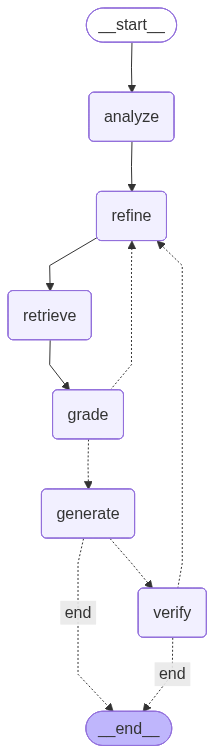

In [96]:
display(Image(adaptive_rag.get_graph().draw_mermaid_png()))

In [97]:
# testing
def test_query_classification():
    """Test the query classification directly"""
    test_queries = [
        "What is LangGraph?",
        "What are the latest developments in quantum computing?",
        "Recent advances in AI",
        "How do I use StateGraph?",
    ]
    
    for query in test_queries:
        print(f"\n{'='*60}")
        print(f"Query: {query}")
        
        # Test heuristic
        heuristic = classify_query_heuristic(query)
        print(f"Heuristic: {heuristic}")
        
        # Test LLM
        try:
            response = query_classifier_chain.invoke({"query": query})
            print(f"LLM Response: {response.content[:200]}")
        except Exception as e:
            print(f"LLM Error: {e}")

In [98]:
print("\n" + "="*60)
print("TESTING QUERY CLASSIFICATION")
print("="*60)
test_query_classification()

INFO:__main__:Heuristic classification: simple, needs_current: False
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



TESTING QUERY CLASSIFICATION

Query: What is LangGraph?
Heuristic: {'complexity': 'SIMPLE', 'concepts': ['LangGraph?'], 'needs_current': False, 'in_domain': True}


INFO:__main__:Heuristic classification: current_events, needs_current: True
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


LLM Response: {"complexity": "SIMPLE", "concepts": ["LangGraph"], "needs_current": false, "in_domain": true}

Query: What are the latest developments in quantum computing?
Heuristic: {'complexity': 'CURRENT_EVENTS', 'concepts': ['latest', 'developments', 'quantum', 'computing?'], 'needs_current': True, 'in_domain': False}


INFO:__main__:Heuristic classification: current_events, needs_current: True
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


LLM Response: {"complexity": "SIMPLE", "concepts": ["quantum computing"], "needs_current": false, "in_domain": true}

Query: Recent advances in AI
Heuristic: {'complexity': 'CURRENT_EVENTS', 'concepts': ['Recent', 'advances'], 'needs_current': True, 'in_domain': True}


INFO:__main__:Heuristic classification: simple, needs_current: False
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


LLM Response: {"complexity": "SIMPLE", "concepts": ["Artificial Intelligence"], "needs_current": false, "in_domain": true}

Query: How do I use StateGraph?
Heuristic: {'complexity': 'SIMPLE', 'concepts': ['StateGraph?'], 'needs_current': False, 'in_domain': True}
LLM Response: {"complexity": "SIMPLE", "concepts": ["StateGraph"], "needs_current": false, "in_domain": true}


In [99]:
def query_adaptive_rag(
    question: str,
    session_id: str = "default",
    max_iterations: int = 3
) -> dict:
    """
    Query adaptive RAG system.
    
    Args:
        question: User question
        session_id: Session identifier
        max_iterations: Maximum retrieval iterations
    
    Returns:
        dict with answer and comprehensive metadata
    """
    
    config = {
        "configurable": {
            "thread_id": f"adaptive-rag-{session_id}"
        }
    }
    
    initial_state = {
        "messages": [HumanMessage(content=question)],
        "original_query": "",
        "query_complexity": "simple",
        "refined_query": "",
        "query_concepts": [],
        "retrieved_docs": [],
        "web_results": [],
        "retrieval_strategy": "vector",
        "relevance_scores": [],
        "overall_relevance": 0.0,
        "support_score": 0.0,
        "needs_web_search": False,
        "generated_answer": "",
        "answer_confidence": 0.0,
        "sources_used": [],
        "iteration": 0,
        "max_iterations": max_iterations,
        "metrics": []
    }
    
    try:
        result = adaptive_rag.invoke(initial_state, config=config)
        
        # Extract metrics
        total_retrieval_time = sum(m.retrieval_time for m in result["metrics"])
        
        return {
            "result": result,
            "success": True,
            "answer": result["generated_answer"],
            "metadata": {
                "query_complexity": result["query_complexity"],
                "retrieval_strategy": result["retrieval_strategy"],
                "sources_used": result["sources_used"],
                "iterations": result["iteration"],
                "overall_relevance": result["overall_relevance"],
                "answer_confidence": result.get("answer_confidence", 0.0),
                "docs_retrieved": len(result["retrieved_docs"]),
                "web_results": len(result["web_results"]),
                "total_retrieval_time": total_retrieval_time,
                "metrics": [
                    {
                        "iteration": m.iteration,
                        "strategy": m.strategy_used,
                        "docs": m.docs_retrieved,
                        "relevance": m.relevance_score,
                        "time": m.retrieval_time
                    }
                    for m in result["metrics"]
                ]
            }
        }
    
    except Exception as e:
        logger.error(f"Query failed: {e}")
        return {
            "success": False,
            "error": str(e)
        }


In [100]:
print("\n" + "="*60)
print("ADAPTIVE RAG SYSTEM DEMO")
print("="*60)

test_questions = [
    "What is LangGraph?",  # Simple, in-domain
    "How do LangGraph nodes, edges, and checkpointing work together?",  # Complex
    "Explain the difference between StateGraph and conditional routing, and how they enable multi-agent systems",  # Multi-hop
    "What are the latest developments in quantum computing?",  # Current events, out-of-domain
]

for i, question in enumerate(test_questions, 1):
    print(f"\n{'='*60}")
    print(f"QUESTION {i}: {question}")
    print(f"{'='*60}")
    
    result = query_adaptive_rag(question, session_id=f"demo-{i}")
    
    if result["success"]:
        meta = result["metadata"]
        
        print(f"\n✅ ANSWER:")
        print(result["answer"])
        
        print(f"\n📊 METADATA:")
        print(f"  Query Complexity: {meta['query_complexity']}")
        print(f"  Strategy: {meta['retrieval_strategy']}")
        print(f"  Sources: {meta['sources_used']}")
        print(f"  Iterations: {meta['iterations']}")
        print(f"  Relevance: {meta['overall_relevance']:.1f}/10")
        print(f"  Confidence: {meta['answer_confidence']:.1f}/10")
        print(f"  Docs Retrieved: {meta['docs_retrieved']}")
        print(f"  Web Results: {meta['web_results']}")
        print(f"  Total Time: {meta['total_retrieval_time']:.2f}s")
        
        print(f"\n📈 ITERATION DETAILS:")
        for metric in meta['metrics']:
            print(f"  Iteration {metric['iteration']}: {metric['strategy']} - {metric['docs']} docs, relevance {metric['relevance']:.1f}, {metric['time']:.2f}s")
    else:
        print(f"\n❌ ERROR: {result['error']}")

INFO:__main__:Analyzing query: What is LangGraph?
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"



ADAPTIVE RAG SYSTEM DEMO

QUESTION 1: What is LangGraph?


INFO:__main__:Raw LLM response: {"complexity": "SIMPLE", "concepts": ["LangGraph"], "needs_current": false, "in_domain": true}
INFO:__main__:✓ Classification - Complexity: simple, Needs current: False, Concepts: ['LangGraph']
INFO:__main__:Refining query for better retrieval
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Refined query: To optimize the query for vector search, we can re...
INFO:__main__:🔍 Retrieval attempt 4 - Complexity: simple, Needs web: False
INFO:__main__:📚 Using VECTOR search strategy
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:✓ Retrieved 3 docs, 0 web results in 0.06s
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Document scores: [8.0, 8.0, 8.0], Overall: 8.0/10


✅ ANSWER:
LangGraph is a library that enables the building of stateful, multi-agent applications with Large Language Models (LLMs). According to [Document 2], LangGraph extends the LangChain Expression Language with graph-based orchestration capabilities, allowing developers to create complex, stateful applications.

Key features of LangGraph include:

1. **State management**: LangGraph has revised its state management system compared to previous versions (0.x), introducing updated import paths and new checkpointing APIs ([Document 1]).
2. **Checkpointing**: LangGraph supports checkpointing using SqliteSaver or MemorySaver, which allows agents to pause execution, save their state, and resume later. This feature is essential for human-in-the-loop patterns ([Document 3]).

Overall, LangGraph provides a powerful toolset for building complex, multi-agent applications with LLMs, enabling developers to create sophisticated stateful systems.

Sources relied upon:

* [Document 1] - Provides i

INFO:__main__:Raw LLM response: {"complexity": "COMPLEX", "concepts": ["LangGraph nodes", "LangGraph edges", "LangGraph checkpointing"], "needs_current": false, "in_domain": true}
INFO:__main__:✓ Classification - Complexity: complex, Needs current: False, Concepts: ['LangGraph nodes', 'LangGraph edges', 'LangGraph checkpointing']
INFO:__main__:Refining query for better retrieval
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Refined query: To optimize the query for vector search, we need t...
INFO:__main__:🔍 Retrieval attempt 1 - Complexity: complex, Needs web: False
INFO:__main__:🔀 Using HYBRID strategy
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:✓ Hybrid web search returned: Latest AI developments include multimodal models, reasoning improvements, and agent frameworks like ...
INFO:__main__:✓ Retrieved 5 docs, 1 web results in 0.07s
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/ap


✅ ANSWER:
Based on the provided knowledge base and web sources, I'll provide a comprehensive explanation of how LangGraph nodes, edges, and checkpointing work together.

**Nodes**: In LangGraph, nodes are Python functions that process state (Document 3). These functions can be thought of as individual tasks or operations within the multi-agent application. The specific implementation details of these functions are not specified in the provided sources, but they are assumed to be defined by the user.

**Edges**: Edges in LangGraph represent transitions between nodes (Document 3). They define the flow of control between different parts of the graph. Edges can be either deterministic or conditional, depending on the implementation. Deterministic edges follow a fixed sequence, while conditional edges use router functions to decide which node to transition to next (Document 5).

**Conditional Edges**: Conditional edges in LangGraph use router functions to dynamically determine the next nod

INFO:__main__:Raw LLM response: {"complexity": "COMPLEX", "concepts": ["StateGraph", "conditional routing", "multi-agent systems"], "needs_current": false, "in_domain": true}
INFO:__main__:✓ Classification - Complexity: complex, Needs current: False, Concepts: ['StateGraph', 'conditional routing', 'multi-agent systems']
INFO:__main__:Refining query for better retrieval
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Refined query: To optimize the query for vector search, we need t...
INFO:__main__:🔍 Retrieval attempt 1 - Complexity: complex, Needs web: False
INFO:__main__:🔀 Using HYBRID strategy
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:✓ Hybrid web search returned: Web search performed for 'To optimize the query for vector search, we need to identify the key conce...
INFO:__main__:✓ Retrieved 5 docs, 1 web results in 0.06s
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HT


✅ ANSWER:
Based on the provided sources, I will explain the difference between StateGraph and conditional routing in multi-agent systems.

**StateGraph**

According to Document 2, StateGraph is the main class in LangGraph, a library for building stateful, multi-agent applications with LLMs. It allows users to define nodes (Python functions that process state) and edges (transitions between nodes). The graph is then compiled into a runnable application.

StateGraph enables multi-agent systems by providing a structured way to represent the state transitions of an agent or system. This data structure can be used to model complex interactions between agents, making it easier to reason about their behavior and design more efficient control strategies.

**Conditional Routing**

Document 5 mentions that LangGraph supports conditional edges, which use router functions to decide the next node dynamically. The router signature is defined as: `def router(state: State) -> str`, returning the name

INFO:__main__:Raw LLM response: {"complexity": "SIMPLE", "concepts": ["quantum computing"], "needs_current": false, "in_domain": true}
INFO:__main__:✓ Classification - Complexity: simple, Needs current: False, Concepts: ['quantum computing']
INFO:__main__:🔍 Retrieval attempt 1 - Complexity: simple, Needs web: False
INFO:__main__:📚 Using VECTOR search strategy
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:__main__:✓ Retrieved 3 docs, 0 web results in 0.05s
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Document scores: [2.0, 2.0, 2.0], Overall: 2.0/10
INFO:__main__:Low relevance (2.0) - retrieving again
INFO:__main__:Refining query for better retrieval
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__


✅ ANSWER:
I must clarify that the provided documents do not mention quantum computing at all. They appear to be related to LangGraph, a library for building stateful, multi-agent applications with Large Language Models (LLMs).

Given the lack of information about quantum computing in the provided sources, I cannot provide any developments or updates on this topic.

However, I can suggest some general information about quantum computing if you're interested. Quantum computing is a rapidly evolving field, and there have been significant advancements in recent years. Some notable developments include:

* The development of quantum processors with thousands of qubits, such as IBM's 53-qubit quantum processor (Source: IBM Research)
* The creation of quantum algorithms that can solve specific problems much faster than classical computers, such as Shor's algorithm for factorization (Source: Google Quantum AI Lab)
* The demonstration of quantum supremacy, where a quantum computer performs a c

In [86]:
result["result"]

{'messages': [HumanMessage(content='What are the latest developments in quantum computing?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I must clarify that the provided Knowledge Base (KB) sources are not related to quantum computing, but rather to LangGraph, a library for building stateful, multi-agent applications with Large Language Models (LLMs).\n\nUnfortunately, I couldn't find any information on the latest developments in quantum computing from the provided sources. The KB sources only discuss updates and features of LangGraph, while the web sources are not available.\n\nTo provide an accurate answer, I would need to rely on external sources that specifically cover quantum computing research and advancements. If you could provide me with some reliable sources or ask a more general question about quantum computing, I'd be happy to help.\n\nHowever, if you're interested in learning about LangGraph, I can provide information based on the available KB sources: